In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy.stats import iqr
from sklearn.metrics import mean_squared_error

# EDA

In [7]:
# Membaca dataset
df = pd.read_csv('dataset/API_19_DS2_en_csv_v2_144674.csv', skiprows=4)

In [8]:
# Langkah 1: Memahami Struktur Data
print("=== Informasi Dataset ===")
print(df.info())
print("\n=== Kolom yang Tersedia ===")
print(df.columns)
print("\n=== Indikator Unik ===")
print(df['Indicator Name'].unique())

=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13566 entries, 0 to 13565
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    13566 non-null  object 
 1   Country Code    13566 non-null  object 
 2   Indicator Name  13566 non-null  object 
 3   Indicator Code  13566 non-null  object 
 4   1960            1130 non-null   float64
 5   1961            2697 non-null   float64
 6   1962            2717 non-null   float64
 7   1963            2724 non-null   float64
 8   1964            2728 non-null   float64
 9   1965            2748 non-null   float64
 10  1966            2754 non-null   float64
 11  1967            2759 non-null   float64
 12  1968            2771 non-null   float64
 13  1969            2777 non-null   float64
 14  1970            3083 non-null   float64
 15  1971            3229 non-null   float64
 16  1972            3239 non-null   float64
 17  1973 

In [9]:
# Langkah 2: Memilih Indikator (default: SP.URB.TOTL, populasi perkotaan)
indicator_code = 'SP.URB.TOTL'  # Ganti dengan kode indikator yang relevan, misalnya 'EN.ATM.CO2E.KT'
df_indicator = df[df['Indicator Code'] == indicator_code]

# Memeriksa apakah indikator ada
if df_indicator.empty:
    print(f"\n=== Peringatan ===\nIndikator {indicator_code} tidak ditemukan dalam dataset.")
    print("Silakan pilih indikator lain dari daftar di atas.")
else:
    print(f"\n=== Data untuk Indikator {indicator_code} ===")
    print(df_indicator.head())


=== Data untuk Indikator SP.URB.TOTL ===
                    Country Name Country Code    Indicator Name  \
1                          Aruba          ABW  Urban population   
52   Africa Eastern and Southern          AFE  Urban population   
103                  Afghanistan          AFG  Urban population   
154   Africa Western and Central          AFW  Urban population   
205                       Angola          AGO  Urban population   

    Indicator Code        1960        1961        1962        1963  \
1      SP.URB.TOTL     27887.0     28212.0     28580.0     28917.0   
52     SP.URB.TOTL  18960189.0  19796785.0  20690699.0  21653526.0   
103    SP.URB.TOTL    759034.0    800151.0    844139.0    890912.0   
154    SP.URB.TOTL  14361518.0  15050171.0  15775196.0  16550889.0   
205    SP.URB.TOTL    545923.0    572465.0    599897.0    628663.0   

           1964        1965  ...         2016         2017         2018  \
1       29221.0     29502.0  ...      46961.0      47075.0 

In [10]:
# Langkah 3: Cek Missing Values
print("\n=== Persentase Missing Values per Kolom ===")
missing_values = df_indicator[[str(year) for year in range(1960, 2025)]].isnull().mean() * 100
print(missing_values)

# Visualisasi Pola Missing Values (jika data tidak kosong)
if not df_indicator.empty:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_indicator[[str(year) for year in range(1960, 2025)]].isnull(), cbar=False, cmap='viridis')
    plt.title(f'Pola Missing Values untuk {indicator_code} (1960–2024)')
    plt.xlabel('Tahun')
    plt.ylabel('Observasi')
    plt.show()

    # Statistik Deskriptif Missing Values
    print("\n=== Statistik Missing Values ===")
    print(f"Total missing values: {df_indicator[[str(year) for year in range(1960, 2025)]].isnull().sum().sum()}")
    print(f"Rata-rata persentase missing per tahun: {missing_values.mean():.2f}%")


=== Persentase Missing Values per Kolom ===
1960      1.503759
1961      1.503759
1962      1.503759
1963      1.503759
1964      1.503759
           ...    
2020      1.127820
2021      1.127820
2022      1.127820
2023      1.127820
2024    100.000000
Length: 65, dtype: float64



=== Statistik Missing Values ===
Total missing values: 488
Rata-rata persentase missing per tahun: 2.82%


In [12]:
# Langkah 4: Statistik Deskriptif dan Visualisasi Tren untuk Satu Negara (contoh: Aruba)
country = 'Aruba'
df_country = df_indicator[df_indicator['Country Name'] == country]

if not df_country.empty:
    # Mengambil data tahun (1960–2024)
    years = [str(year) for year in range(1960, 2025)]
    data_values = df_country[years].T
    data_values.columns = ['Value']
    data_values.index = pd.to_numeric(data_values.index)

    # Statistik Deskriptif
    print(f"\n=== Statistik Deskriptif untuk {indicator_code} di {country} ===")
    print(data_values.describe())

    # Visualisasi Tren Deret Waktu
    plt.figure(figsize=(12, 6))
    plt.plot(data_values.index, data_values['Value'], marker='o')
    plt.title(f'Tren {indicator_code} di {country} (1960–2024)')
    plt.xlabel('Tahun')
    plt.ylabel(indicator_code)
    plt.grid(True)
    plt.show()

    # Langkah 5: Cek Stasionaritas dengan ADF Test
    if data_values['Value'].dropna().shape[0] > 1:  # Memastikan cukup data untuk ADF
        adf_result = adfuller(data_values['Value'].dropna())
        print(f"\n=== ADF Test untuk Stasionaritas ({indicator_code} di {country}) ===")
        print(f'ADF Statistic: {adf_result[0]}')
        print(f'p-value: {adf_result[1]}')
        print('Kesimpulan: Data stasioner jika p-value < 0.05, sebaliknya tidak stasioner')
    else:
        print(f"\n=== Peringatan ===\nData untuk {indicator_code} di {country} tidak cukup untuk ADF Test.")


=== Statistik Deskriptif untuk SP.URB.TOTL di Aruba ===
              Value
count     64.000000
mean   36792.125000
std     7304.268279
min    27887.000000
25%    29831.000000
50%    33824.500000
75%    44069.000000
max    47554.000000



=== ADF Test untuk Stasionaritas (SP.URB.TOTL di Aruba) ===
ADF Statistic: 0.05926606629327267
p-value: 0.963167408274682
Kesimpulan: Data stasioner jika p-value < 0.05, sebaliknya tidak stasioner


In [13]:
# Langkah 6: Cek Duplikasi
print("\n=== Cek Duplikasi ===")
duplicates = df_indicator.duplicated().sum()
print(f'Jumlah baris duplikat: {duplicates}')


=== Cek Duplikasi ===
Jumlah baris duplikat: 0


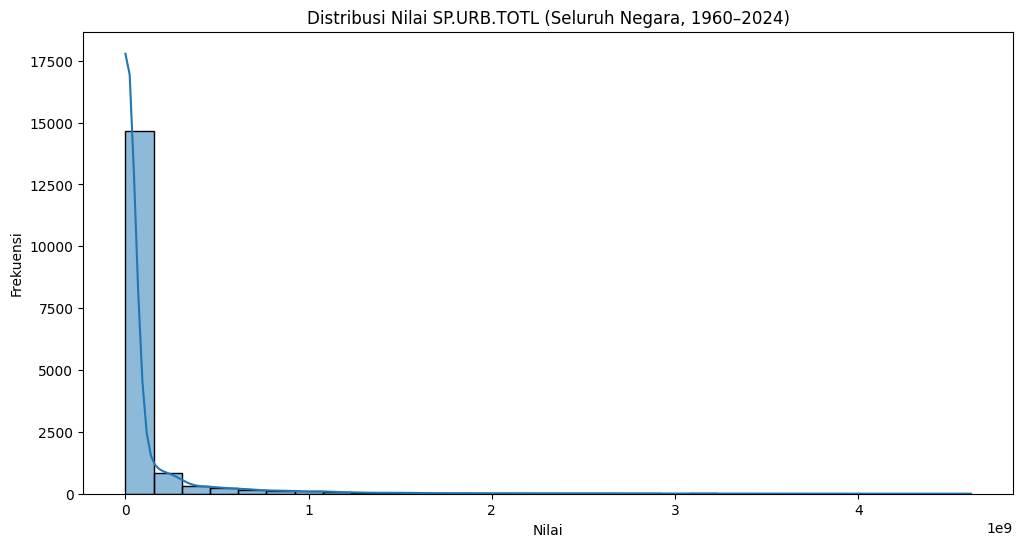


=== Statistik Deskriptif untuk SP.URB.TOTL (Seluruh Negara) ===
count    1.680200e+04
mean     9.484001e+07
std      3.250090e+08
min      8.900000e+02
25%      3.672712e+05
50%      3.000358e+06
75%      2.401446e+07
max      4.614425e+09
Name: value, dtype: float64


In [14]:
# Langkah 7: Visualisasi Distribusi Nilai Indikator (seluruh negara)
if not df_indicator.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_indicator[years].melt()['value'].dropna(), bins=30, kde=True)
    plt.title(f'Distribusi Nilai {indicator_code} (Seluruh Negara, 1960–2024)')
    plt.xlabel('Nilai')
    plt.ylabel('Frekuensi')
    plt.show()

    # Statistik Deskriptif untuk Distribusi
    print(f"\n=== Statistik Deskriptif untuk {indicator_code} (Seluruh Negara) ===")
    print(df_indicator[years].melt()['value'].describe())

In [15]:
# Langkah 8: Analisis Korelasi Antar Indikator (jika ada indikator lain)
indicators = ['SP.URB.TOTL', 'SP.POP.TOTL', 'SP.URB.GROW']  # Indikator yang ada di potongan data
df_selected = df[df['Indicator Code'].isin(indicators)].pivot_table(
    index='Country Name', columns='Indicator Code', values='2020'
).dropna()

if not df_selected.empty:
    # Visualisasi Korelasi
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_selected.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Korelasi Antar Indikator (Tahun 2020)')
    plt.show()

    # Statistik Deskriptif untuk Korelasi
    print("\n=== Matriks Korelasi ===")
    print(df_selected.corr())


=== Matriks Korelasi ===
Indicator Code  SP.POP.TOTL  SP.URB.GROW  SP.URB.TOTL
Indicator Code                                       
SP.POP.TOTL        1.000000     0.087954     0.987958
SP.URB.GROW        0.087954     1.000000     0.051132
SP.URB.TOTL        0.987958     0.051132     1.000000


# Preprocessing

In [17]:
# Langkah 1: Memilih Indikator dan Negara
indicator_code = 'SP.URB.TOTL'  # Populasi perkotaan
country = 'Aruba'
df_indicator = df[df['Indicator Code'] == indicator_code]
df_country = df_indicator[df_indicator['Country Name'] == country]

In [18]:
# Langkah 2: Pemilihan Periode Waktu (1960–2023, menghapus 2024 karena 100% missing)
years = [str(year) for year in range(1960, 2024)]  # Hanya sampai 2023
data_values = df_country[years].T
data_values.columns = ['Value']
data_values.index = pd.to_numeric(data_values.index)


=== Penanganan Missing Values ===
Missing values sebelum interpolasi: 0
Missing values setelah interpolasi: 0


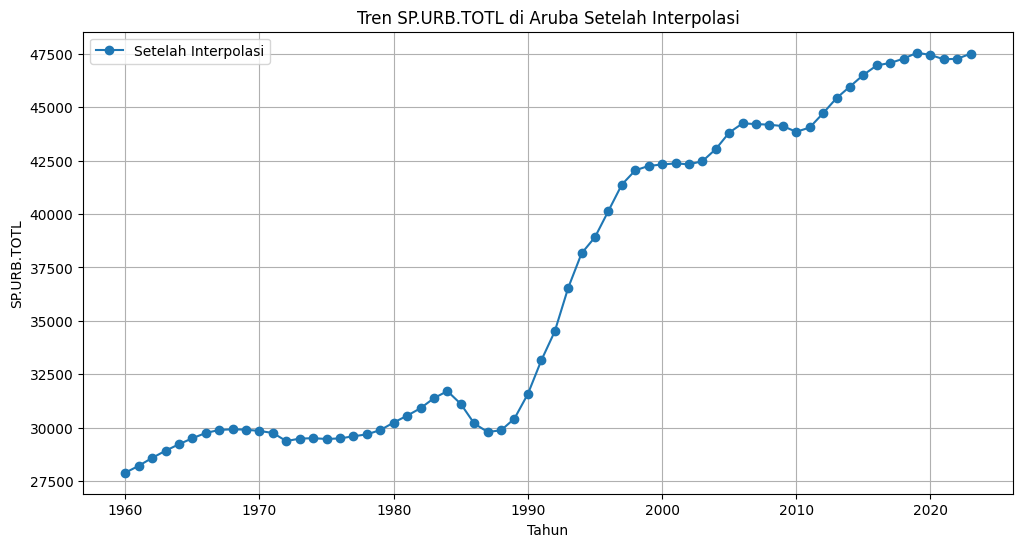


=== Statistik Deskriptif Setelah Interpolasi ===
              Value
count     64.000000
mean   36792.125000
std     7304.268279
min    27887.000000
25%    29831.000000
50%    33824.500000
75%    44069.000000
max    47554.000000


In [19]:
# Langkah 3: Penanganan Missing Values dengan Interpolasi Linier
print("\n=== Penanganan Missing Values ===")
missing_before = data_values['Value'].isnull().sum()
print(f"Missing values sebelum interpolasi: {missing_before}")
data_values['Value'] = data_values['Value'].interpolate(method='linear')
missing_after = data_values['Value'].isnull().sum()
print(f"Missing values setelah interpolasi: {missing_after}")

# Visualisasi Data Setelah Interpolasi
plt.figure(figsize=(12, 6))
plt.plot(data_values.index, data_values['Value'], marker='o', label='Setelah Interpolasi')
plt.title(f'Tren {indicator_code} di {country} Setelah Interpolasi')
plt.xlabel('Tahun')
plt.ylabel(indicator_code)
plt.grid(True)
plt.legend()
plt.show()

# Statistik Deskriptif Setelah Interpolasi
print("\n=== Statistik Deskriptif Setelah Interpolasi ===")
print(data_values.describe())


=== Penanganan Outlier ===
Batas bawah: 8474.0, Batas atas: 65426.0


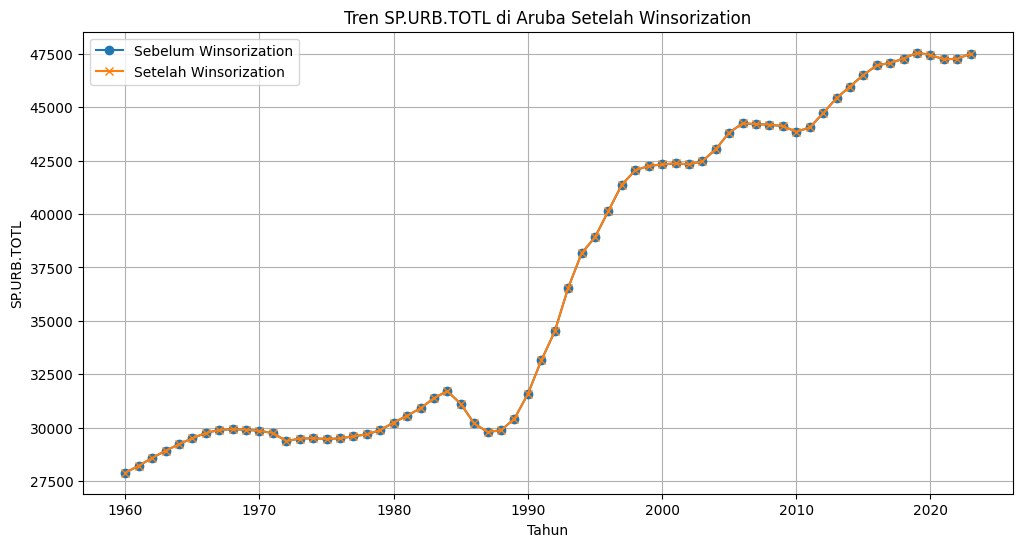


=== Statistik Deskriptif Setelah Winsorization ===
count       64.000000
mean     36792.125000
std       7304.268279
min      27887.000000
25%      29831.000000
50%      33824.500000
75%      44069.000000
max      47554.000000
Name: Value_Winsorized, dtype: float64


In [20]:
# Langkah 4: Penanganan Outlier dengan IQR dan Winsorization
print("\n=== Penanganan Outlier ===")
Q1 = data_values['Value'].quantile(0.25)
Q3 = data_values['Value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Batas bawah: {lower_bound}, Batas atas: {upper_bound}")

# Winsorization: Membatasi nilai di luar batas IQR
data_values['Value_Winsorized'] = data_values['Value'].clip(lower=lower_bound, upper=upper_bound)

# Visualisasi Data Setelah Winsorization
plt.figure(figsize=(12, 6))
plt.plot(data_values.index, data_values['Value'], marker='o', label='Sebelum Winsorization')
plt.plot(data_values.index, data_values['Value_Winsorized'], marker='x', label='Setelah Winsorization')
plt.title(f'Tren {indicator_code} di {country} Setelah Winsorization')
plt.xlabel('Tahun')
plt.ylabel(indicator_code)
plt.grid(True)
plt.legend()
plt.show()

# Statistik Deskriptif Setelah Winsorization
print("\n=== Statistik Deskriptif Setelah Winsorization ===")
print(data_values['Value_Winsorized'].describe())


=== Normalisasi Min-Max ===


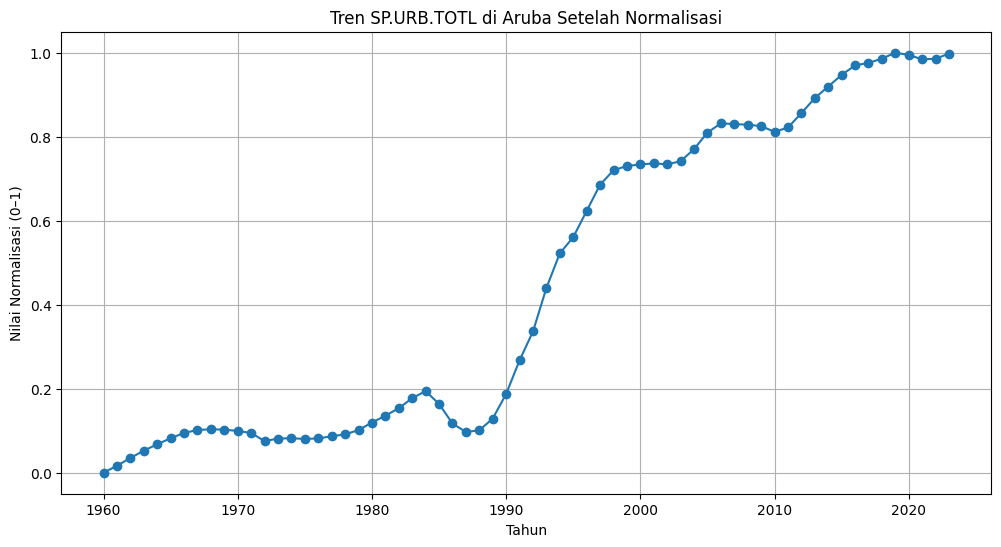

In [21]:
# Langkah 5: Normalisasi Min-Max
print("\n=== Normalisasi Min-Max ===")
data_values['Value_Normalized'] = (data_values['Value_Winsorized'] - data_values['Value_Winsorized'].min()) / (data_values['Value_Winsorized'].max() - data_values['Value_Winsorized'].min())

# Visualisasi Data Setelah Normalisasi
plt.figure(figsize=(12, 6))
plt.plot(data_values.index, data_values['Value_Normalized'], marker='o')
plt.title(f'Tren {indicator_code} di {country} Setelah Normalisasi')
plt.xlabel('Tahun')
plt.ylabel('Nilai Normalisasi (0–1)')
plt.grid(True)
plt.show()

In [22]:
# Statistik Deskriptif Setelah Normalisasi
print("\n=== Statistik Deskriptif Setelah Normalisasi ===")
print(data_values['Value_Normalized'].describe())


=== Statistik Deskriptif Setelah Normalisasi ===
count    64.000000
mean      0.452795
std       0.371397
min       0.000000
25%       0.098846
50%       0.301902
75%       0.822800
max       1.000000
Name: Value_Normalized, dtype: float64


# Modeling


=== Definisi Interval Fuzzy ===
Interval Fuzzy (dalam skala [0, 1]):
A1: [0.000, 0.143]
A2: [0.143, 0.286]
A3: [0.286, 0.429]
A4: [0.429, 0.571]
A5: [0.571, 0.714]
A6: [0.714, 0.857]
A7: [0.857, 1.000]

=== Distribusi Fuzzy Labels ===
Fuzzy_Label
A1    26
A2     6
A3     1
A4     3
A5     2
A6    15
A7    11
Name: count, dtype: int64


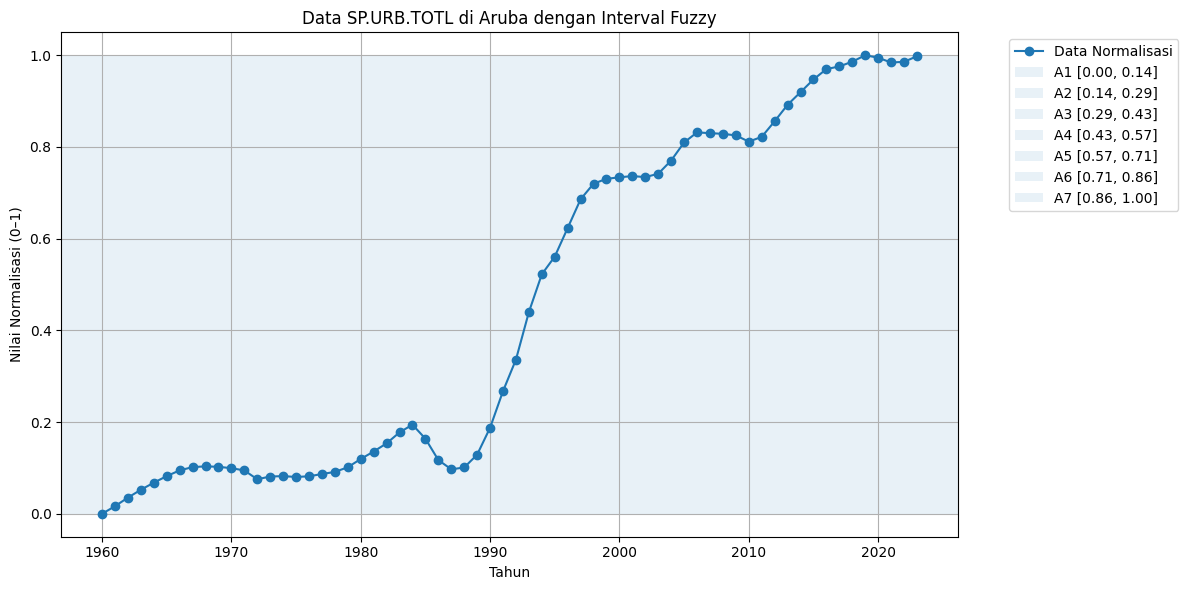

In [24]:
# Langkah 1: Definisi Interval Fuzzy
print("\n=== Definisi Interval Fuzzy ===")
num_intervals = 7  # Jumlah interval fuzzy (misalnya, rendah, sedang, tinggi, dll.)
data_range = data_values['Value_Normalized'].max() - data_values['Value_Normalized'].min()
interval_length = data_range / num_intervals
intervals = [(i * interval_length, (i + 1) * interval_length) for i in range(num_intervals)]
print(f"Interval Fuzzy (dalam skala [0, 1]):")
for i, (start, end) in enumerate(intervals):
    print(f"A{i+1}: [{start:.3f}, {end:.3f}]")

# Menetapkan label fuzzy untuk setiap data
def assign_fuzzy_label(value, intervals):
    for i, (start, end) in enumerate(intervals):
        if start <= value < end:
            return f"A{i+1}"
    return f"A{num_intervals}"  # Untuk nilai maksimum

data_values['Fuzzy_Label'] = data_values['Value_Normalized'].apply(lambda x: assign_fuzzy_label(x, intervals))

# Statistik Deskriptif untuk Fuzzy Labels
print("\n=== Distribusi Fuzzy Labels ===")
print(data_values['Fuzzy_Label'].value_counts().sort_index())

# Visualisasi Data dengan Interval Fuzzy
plt.figure(figsize=(12, 6))
plt.plot(data_values.index, data_values['Value_Normalized'], marker='o', label='Data Normalisasi')
for i, (start, end) in enumerate(intervals):
    plt.axhspan(start, end, alpha=0.1, label=f'A{i+1} [{start:.2f}, {end:.2f}]')
plt.title(f'Data SP.URB.TOTL di Aruba dengan Interval Fuzzy')
plt.xlabel('Tahun')
plt.ylabel('Nilai Normalisasi (0–1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Langkah 2: Fuzzifikasi dengan Derajat Keanggotaan
# Fungsi keanggotaan triangular sederhana
def triangular_membership(value, intervals):
    membership = {}
    for i, (start, end) in enumerate(intervals):
        mid = (start + end) / 2
        if start <= value <= end:
            if value <= mid:
                membership[f"A{i+1}"] = (value - start) / (mid - start) if mid != start else 1.0
                if i > 0:
                    prev_mid = (intervals[i-1][0] + intervals[i-1][1]) / 2
                    membership[f"A{i}"] = (intervals[i-1][1] - value) / (intervals[i-1][1] - prev_mid) if intervals[i-1][1] != prev_mid else 0.0
            else:
                membership[f"A{i+1}"] = (end - value) / (end - mid) if end != mid else 1.0
                if i < len(intervals) - 1:
                    next_mid = (intervals[i+1][0] + intervals[i+1][1]) / 2
                    membership[f"A{i+2}"] = (value - end) / (next_mid - end) if next_mid != end else 0.0
        else:
            membership[f"A{i+1}"] = 0.0
    return membership

# Menghitung derajat keanggotaan untuk setiap data
data_values['Membership'] = data_values['Value_Normalized'].apply(lambda x: triangular_membership(x, intervals))
print("\n=== Contoh Derajat Keanggotaan (5 Data Pertama) ===")
print(data_values[['Value_Normalized', 'Fuzzy_Label', 'Membership']].head())


=== Contoh Derajat Keanggotaan (5 Data Pertama) ===
      Value_Normalized Fuzzy_Label  \
1960          0.000000          A1   
1961          0.016525          A1   
1962          0.035237          A1   
1963          0.052372          A1   
1964          0.067829          A1   

                                             Membership  
1960  {'A1': 0.0, 'A2': 0.0, 'A3': 0.0, 'A4': 0.0, '...  
1961  {'A1': 0.23135201098286473, 'A2': 0.0, 'A3': 0...  
1962  {'A1': 0.49331367264961606, 'A2': 0.0, 'A3': 0...  
1963  {'A1': 0.7332079117303096, 'A2': 0.0, 'A3': 0....  
1964  {'A1': 0.9496110235419738, 'A2': 0.0, 'A3': 0....  



=== Frekuensi Hubungan Fuzzy ===
A1 -> A1    24
A1 -> A2     2
A2 -> A1     1
A2 -> A2     4
A2 -> A3     1
A3 -> A4     1
A4 -> A4     2
A4 -> A5     1
A5 -> A5     1
A5 -> A6     1
A6 -> A6    14
A6 -> A7     1
A7 -> A7    10
Name: count, dtype: int64


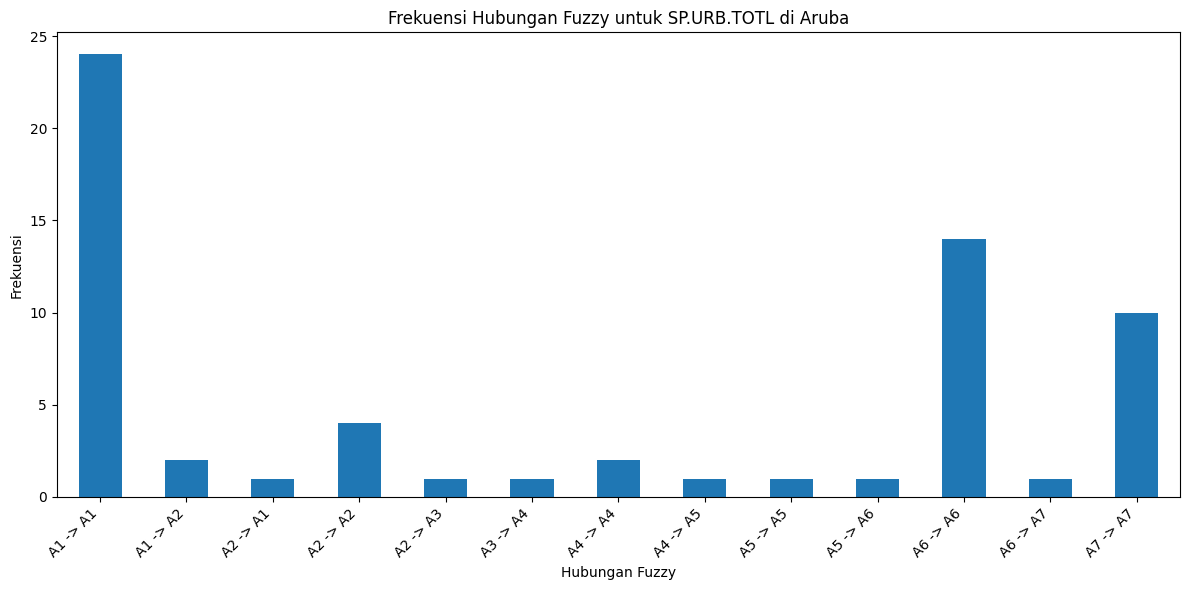

In [26]:
# Langkah 3: Pembangunan Hubungan Fuzzy (Fuzzy Logical Relationships, FLR)
flr = []
for i in range(len(data_values) - 1):
    current_label = data_values['Fuzzy_Label'].iloc[i]
    next_label = data_values['Fuzzy_Label'].iloc[i + 1]
    flr.append(f"{current_label} -> {next_label}")

# Statistik Hubungan Fuzzy
flr_counts = pd.Series(flr).value_counts().sort_index()
print("\n=== Frekuensi Hubungan Fuzzy ===")
print(flr_counts)

# Visualisasi Hubungan Fuzzy
plt.figure(figsize=(12, 6))
flr_counts.plot(kind='bar')
plt.title('Frekuensi Hubungan Fuzzy untuk SP.URB.TOTL di Aruba')
plt.xlabel('Hubungan Fuzzy')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Evaluasi

In [28]:
# Langkah 1: Membangun Fuzzy Logical Relationship Groups (FLRG)
flr = [(data_values['Fuzzy_Label'].iloc[i], data_values['Fuzzy_Label'].iloc[i + 1]) for i in range(len(data_values) - 1)]
flrg = {}
for current, next_label in flr:
    if current not in flrg:
        flrg[current] = []
    flrg[current].append(next_label)

# Menampilkan FLRG
print("\n=== Fuzzy Logical Relationship Groups (FLRG) ===")
for current, next_labels in flrg.items():
    print(f"{current} -> {', '.join(next_labels)}")


=== Fuzzy Logical Relationship Groups (FLRG) ===
A1 -> A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A2, A1, A1, A1, A2
A2 -> A2, A2, A2, A1, A2, A3
A3 -> A4
A4 -> A4, A4, A5
A5 -> A5, A6
A6 -> A6, A6, A6, A6, A6, A6, A6, A6, A6, A6, A6, A6, A6, A6, A7
A7 -> A7, A7, A7, A7, A7, A7, A7, A7, A7, A7


In [31]:
# Langkah 2: Prediksi
predictions = []
for i in range(len(data_values) - 1):
    current_label = data_values['Fuzzy_Label'].iloc[i]
    if current_label in flrg:
        # Menggunakan pusat interval fuzzy dari label yang mungkin di t+1
        next_labels = flrg[current_label]
        predicted_value = np.mean([np.mean(intervals[int(label[1:]) - 1]) for label in next_labels])
        predictions.append(predicted_value)
    else:
        predictions.append(np.nan)  # Jika tidak ada hubungan, prediksi NaN

# Menambahkan prediksi ke data_values (disesuaikan untuk t+1)
data_values['Predicted_Normalized'] = np.nan
data_values['Predicted_Normalized'].iloc[1:] = predictions

C:\Users\Michael Angello\AppData\Local\Temp\ipykernel_2596\939634532.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_values['Predicted_Normalized'].iloc[1:] = predictions
C:\Users\Michael Angello\AppData\Local\Temp\ipykernel_2596\9

In [32]:
# Langkah 3: Defuzzifikasi ke Skala Asli
min_value = data_values['Value_Winsorized'].min()
max_value = data_values['Value_Winsorized'].max()
data_values['Predicted'] = data_values['Predicted_Normalized'] * (max_value - min_value) + min_value

# Statistik Deskriptif Prediksi
print("\n=== Statistik Deskriptif Prediksi ===")
print(data_values[['Value_Winsorized', 'Predicted']].describe())


=== Statistik Deskriptif Prediksi ===
       Value_Winsorized     Predicted
count         64.000000     63.000000
mean       36792.125000  36694.783447
std         7304.268279   7106.435291
min        27887.000000  29507.906593
25%        29831.000000  29507.906593
50%        33824.500000  32101.357143
75%        44069.000000  43526.947619
max        47554.000000  46149.214286


In [33]:
# Langkah 4: Evaluasi dengan RMSE
rmse = np.sqrt(mean_squared_error(data_values['Value_Winsorized'].iloc[1:], data_values['Predicted'].iloc[1:]))
print(f"\n=== Evaluasi Prediksi ===")
print(f"RMSE (skala asli): {rmse:.2f}")


=== Evaluasi Prediksi ===
RMSE (skala asli): 931.20


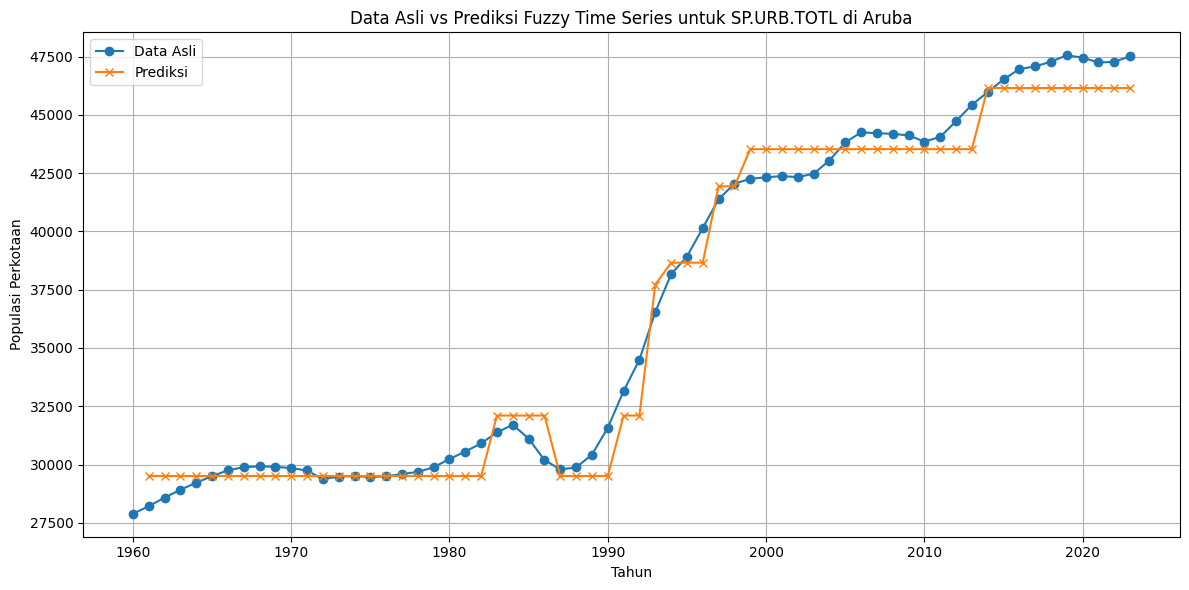

In [34]:
# Langkah 5: Visualisasi Data Asli vs Prediksi
plt.figure(figsize=(12, 6))
plt.plot(data_values.index, data_values['Value_Winsorized'], marker='o', label='Data Asli')
plt.plot(data_values.index, data_values['Predicted'], marker='x', label='Prediksi')
plt.title('Data Asli vs Prediksi Fuzzy Time Series untuk SP.URB.TOTL di Aruba')
plt.xlabel('Tahun')
plt.ylabel('Populasi Perkotaan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prediksi

C:\Users\Michael Angello\AppData\Local\Temp\ipykernel_2596\1481625925.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_values_extended = pd.concat([data_values, pd.DataFrame(index=future_years, columns=data_values.columns)])


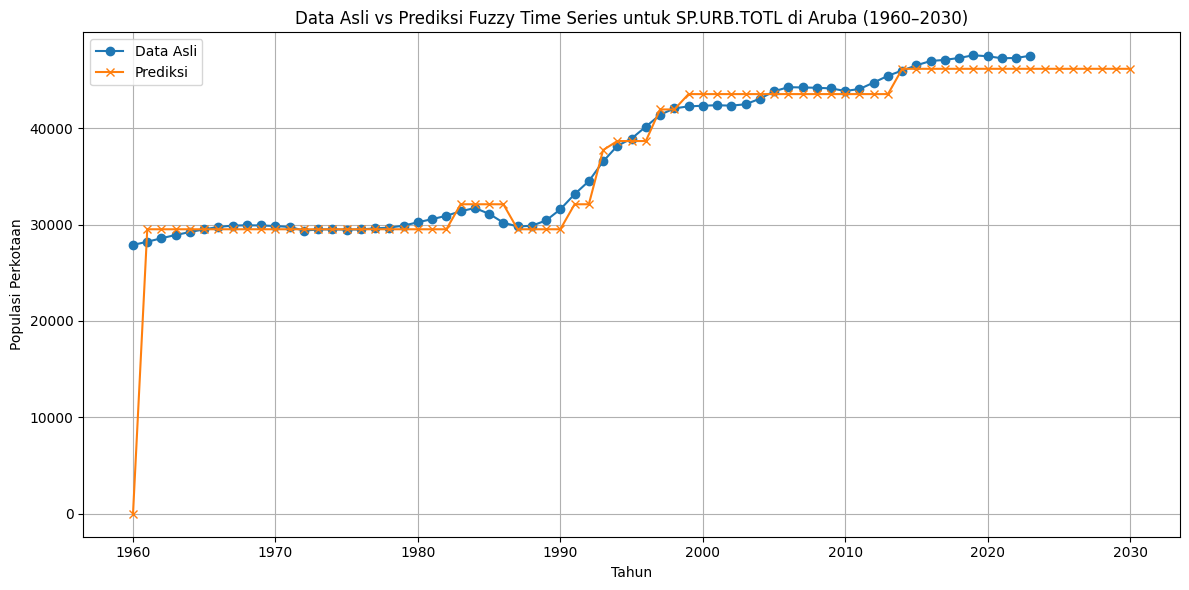

In [35]:
# Membangun FLRG
flr = [(data_values['Fuzzy_Label'].iloc[i], data_values['Fuzzy_Label'].iloc[i + 1]) for i in range(len(data_values) - 1)]
flrg = {}
for current, next_label in flr:
    if current not in flrg:
        flrg[current] = []
    flrg[current].append(next_label)

# Prediksi untuk data masa depan (2024–2030)
future_years = range(2024, 2031)
future_predictions = []
last_label = data_values['Fuzzy_Label'].iloc[-1]  # Label terakhir (2023)

for _ in future_years:
    if last_label in flrg:
        next_labels = flrg[last_label]
        predicted_value = np.mean([np.mean(intervals[int(label[1:]) - 1]) for label in next_labels])
        future_predictions.append(predicted_value)
        # Update label terakhir berdasarkan prediksi
        last_label = assign_fuzzy_label(predicted_value, intervals)
    else:
        future_predictions.append(np.nan)

# Defuzzifikasi ke skala asli
min_value = data_values['Value_Winsorized'].min()
max_value = data_values['Value_Winsorized'].max()
future_predictions_defuzzified = [pred * (max_value - min_value) + min_value for pred in future_predictions]

# Menggabungkan prediksi masa depan dengan data asli
future_data = pd.DataFrame({
    'Year': future_years,
    'Predicted': future_predictions_defuzzified
})
data_values_extended = pd.concat([data_values, pd.DataFrame(index=future_years, columns=data_values.columns)])
data_values_extended['Predicted'] = data_values_extended['Predicted'].fillna(0)
data_values_extended.loc[future_years, 'Predicted'] = future_predictions_defuzzified

# Visualisasi Data Asli vs Prediksi (termasuk masa depan)
plt.figure(figsize=(12, 6))
plt.plot(data_values.index, data_values['Value_Winsorized'], marker='o', label='Data Asli')
plt.plot(data_values_extended.index, data_values_extended['Predicted'], marker='x', label='Prediksi')
plt.title('Data Asli vs Prediksi Fuzzy Time Series untuk SP.URB.TOTL di Aruba (1960–2030)')
plt.xlabel('Tahun')
plt.ylabel('Populasi Perkotaan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()